# <center> Сегментация клиентов онлайн магазина подарков

## Постановка задачи


<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

Маркетинг — неотъемлемая часть любого бизнеса. Для повышения прибыли компании важно понимать своего клиента, его пожелания и предпочтения. С появлением электронной коммерции, или онлайн-продаж, стало намного проще собирать данные о клиентах, анализировать их, находить закономерности и реализовывать маркетинговые кампании.

Большинство интернет-магазинов используют инструменты веб-аналитики, чтобы отслеживать просмотры страниц, количество и поведение посетителей и коэффициент отказов. Но отчёта из Google Analytics или аналогичной системы может быть недостаточно для полного понимания того, как клиенты взаимодействуют с сайтом. Компаниям важно иметь возможность быстро и точно реагировать на перемены в поведении клиентов, создавая инструменты, которые обнаруживают эти изменения практически в режиме реального времени.

Машинное обучение помогает поисковой системе анализировать огромное количество данных о посетителях платформы, узнавать модели поведения профессиональных покупателей, определять категорию клиентов (например, лояльные/перспективные/новички/спящие/ушедшие) и выбирать правильную стратегию взаимодействия с ними.

Стоит также отметить, что компании, использующие машинное обучение на своих платформах электронной коммерции, могут постоянно повышать эффективность бизнес-процессов: настраивать товарную выборку персонально для каждого покупателя и предлагать выгодную цену в соответствии с бюджетом клиента и т. д. Эта задача относится к категории построения рекомендательных систем, речь о которых пойдёт в следующем разделе нашего курса.

> Как правило, наборы данных для электронной коммерции являются частной собственностью и, следовательно, их трудно найти среди общедоступных данных. Однако [The UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php)  создал набор данных, содержащий фактические транзакции за 2010 и 2011 годы. С ним нам как раз и предлагается поработать в этом кейсе.

> В нашем распоряжении будет набор данных, который содержит все транзакции, произошедшие в период с 01/12/2010 по 09/12/2011 для базирующейся в Великобритании компании, занимающейся онлайн-розничной торговлей. Компания в основном продает уникальные подарки на все случаи жизни. Многие клиенты компании являются оптовиками.


**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача для вас как для специалиста в Data Science:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку исходного набора данных о транзакциях.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать набор данных о характеристиках каждого из уникальных клиентов.
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать вашу модель на новых клиентах.




## Данные и их описание

Данные представляют собой таблицу в формате CSV, в каждой строке которой содержится информация об уникальной транзакции.

Признаки, описывающие каждую транзакцию:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* StockCode — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию;
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.



Импорт базовых библиотек:

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

import re

from googleapiclient.discovery import build

import warnings

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

## 1. Знакомство со структурой данных

Первым делом необходимо понять, с какими данными предстоит работать, и произвести базовую предобработку данных — перевести признаки в необходимые для дальнейшей работы форматы.

Познакомьтесь с исходными данными поближе:

* Проведите статистический анализ исходных данных, посмотрев на основные диапазоны исходных признаков.
* Узнайте, сколько уникальных клиентов совершали транзакции в указанный период.
* Узнайте, из каких стран совершались транзакции.
* Исследуйте данные на наличие пропусков и дубликатов.
* Переведите столбцы в корректные форматы (например, даты в формат datetime).

In [3]:
data = pd.read_csv(
    "data.csv",
    encoding="ISO-8859-1",
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data.shape))
data.head(5)

FileNotFoundError: [Errno 2] No such file or directory: 'data.csv'

In [ ]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
print('Date interval {} to {}'.format(data['InvoiceDate'].dt.date.min(), data['InvoiceDate'].dt.date.max()))

## 2. Преобразование, очистка и анализ данных

### 2.1. Преобразование и очистка данных о транзакциях

#### 2.1.1 Пропуски

Пропуски в столбце с идентификатором клиента (CustomerID) и описанием товара свидетельствуют о некорректных/незавершённых транзакциях. Удалите их из данных.

**Примечание.** Если посмотреть на распределение пропусков в столбцах Description и CustomerID, то можно заметить, что достаточно удалить строки, содержащие пропуски в столбце CustomerID, тогда пропуски в столбце Description удаляются автоматически.


In [ ]:
print('Пропуски в наборе данных:')
display(data.isnull().sum())
# Удаляем все строки содержащие хотябы один пропуск
data = data.dropna()

#### 2.1.2. Дубликаты

Проверьте данные на наличие дубликатов. Удалите их из данных.


In [ ]:
# Удаляем полные дубликаты
print('Количество полных дубликатов: ', data[data.duplicated()].shape[0])
print('Процент полных дубликатов: {}%'.format(
     round(data[data.duplicated()].shape[0] / data.shape[0] * 100, 1), 10))
print('Пример полного дубликата:')
data[(data['InvoiceNo']=='536409')&(data['StockCode']=='21866')]
#print('Размер датасета до удаления полных дубликатов: ', data.shape)
#data = data.drop_duplicates()
#print('Размер датасета после удаления полных дубликатов: ', data.shape)

In [ ]:
print('Количество не полных дубликатов (пары InvoiceNo и StockCode дублируются): ',
        data[data.duplicated(subset=['InvoiceNo', 'StockCode'])].shape[0])
print('Пример неполного дбликата:')
display(data[(data['InvoiceNo']=='536409')&(data['StockCode']=='90199C')])

*Чем отличаются данные два примера по своей природе? Скорее всего, ни чем. Почему же тогда нужно удалять полные дубликаты? Только лишь по тому, что в полных количество товара одинаково? И оставлять не полные, у которых количество товара разное? А если предположить, что причина возникновения полных дубликатов и неполных скорее всего одна. Это может быть особенностью онлайн-магазина, в полне возможно в одной счет-фактуре одно наименование товара, фиксируется в разных позициях по причине разных поставок товара. Давайте копнем дальше и посмотрим совпадает ли количество дубликатов по полям: InvoiceNo, StockCode, с дубликатами по полям: InvoiceNo, StockCode, Description, InvoiceDate.*

In [ ]:
print('Количество не полных дубликатов (дублируются: InvoiceNo StockCode, Description и InvoiceDate): ',
    data[data.duplicated(subset=['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate'])].shape[0])

*Видим, что количество дубликатов по полям: InvoiceNo, StockCode, почти совпадает с количеством дубликатов по полям: InvoiceNo, StockCode, Description, InvoiceDate (за исключением единичных случаев). О чем это говорит? О том, что практически везде, где есть неполные дубликаты по полям: InvoiceNo, StockCode, у них везде дублируются InvoiceDate и Description. Но это совсем не значит, что в одной счет-фактуре разное время по позициям с разными товарами, на против, в каждой счет-фактуре мы видим одно и тоже время, см. пример.*

In [ ]:
print('Пример счета-фактуры, в которой несколько сотен позиций, но при этом одно и тоже время:')
display(data[data['InvoiceNo']=='576339'].head(5))
print('Количество уникальных кодов товара в данной счет-фактуре:')
print(data[data['InvoiceNo']=='576339'].groupby(['StockCode']).count().shape[0])
print('Количество уникальных значений поле InvoiceDate в данной счет-фактуре:')
print(data[data['InvoiceNo']=='576339'].groupby(['InvoiceDate']).count().shape[0])

*Данный пример, является основанием утверждать, что в каждой счете-фактуре одно и тоже время, за исключением некоторых единичных случаев:*

In [ ]:
print('Примеры накладных, в которых может зафиксировано разное время:')
display(data[data['InvoiceNo']=='536591'].groupby(['InvoiceNo', 'InvoiceDate'])['InvoiceNo'].count())
display(data[data['InvoiceNo']=='578548'].groupby(['InvoiceNo', 'InvoiceDate'])['InvoiceNo'].count())

Таких накладных не много:

In [ ]:
group1 = data.groupby(['InvoiceNo', 'InvoiceDate'], as_index=False).count()
group2 = group1.groupby('InvoiceNo', as_index=False)['InvoiceDate'].count()
print('Процент счетов-фактур с количеством уникальных значений InvoiceDate более одного: {}%'.format(
        round(group2[group2['InvoiceDate']>1].shape[0] / data.groupby(['InvoiceNo']).count().shape[0] * 100, 2)
        ))

*Как видим у нас нет оснований пологать, что полные дубликаты в данном конкретном датасете являются признаком программного сбоя или ошибки ввода, это скорее всего особенность БД онлайн-магазина. И удалять эти так называемые полные дубликаты необоснованно, скорее всего будет причиной внесения некоторых искажений в последующей кластеризации, которая кстати выполняется на основе, не данного датасета, а агрегированной выборки-RFM, там то, как раз не будет дубликатов, т.к. выборка RFM формируется на основе группировки по коду покупателя, а это гарантирует отсутствие дублирующихся записей.*

*Кроме того некоторые единичные товары, по непонятным причинам могут иметь разные Description, см. примеры ниже.*

In [ ]:
print('Примеры товаров, в которых разные Description:')
display(data[data['StockCode']=='20914'].groupby(['StockCode', 'Description'])['InvoiceNo'].count())
display(data[data['StockCode']=='20725'].groupby(['StockCode', 'Description'])['InvoiceNo'].count())

*Скорее всего это какая то недоработка в ПО онлайн-магазина, т.е. по данному факту, мы видим, что БД онлайн-магазина не является реляционной, ее структура не обеспечивает исключения случаев нарушения целосности данных. Итого в сухом остатке мы имеем, сл. выводы:*
- *в счете-фактуре могут быть сотни позиций с одним и тем же временем, практически в 100% счетов-фактур время в каждой счете-фактуре одно и тоже (за исключением единичных случаев);*
- *в единичных случаях один код товара может иметь более одного наименования;*
- *в счете-фактуре могут встречаться несколько позиций по одному наименованию товара с одним и темже или разым количеством.*  

*Поэтому предлогаю не удалять дубликаты.*

#### 2.1.3. Транзакции с отрицательным количеством товара

Из приведённых выше инсайтов о данных мы узнали все особенности отмены заказов. Когда мы будем сегментировать клиентов, мы будем определять их покупательскую способность. При расчёте покупательской способности нам будет очень важно учесть возвраты этого клиента.

Чтобы подсчитать количество возвратов, для начала нам надо определить, сколько уникальных товаров указано в транзакции (корзине) для каждой уникальной пары «клиент — заказ»:


In [ ]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

**Примечание.** Более 16 % уникальных заказов являются возвратами. Интересный факт: если мы подсчитали количество транзакций, содержащих признак возврата, в изначальной таблице, где на каждый уникальный товар заведена отдельная строка, то мы получили бы, что количество возвратов менее 1 %. Однако это число было бы некорректным.

Создайте в ваших данных о транзакциях признак `QuantityCanceled`. Этот признак будет указывать на количество отменённого впоследствии товара для каждой транзакции, на которую найдётся противоположная ей транзакция с возвратом. Для транзакций, для которых не было возвратов, признак будет равен 0. Для транзакций, для которых указано отрицательное количество товара, но в данных отсутствует контрагент, признак будет пустым.

В качестве вспомогательного инструмента мы подготовили для вас функцию `get_quantity_canceled()`. Эта функция принимает на вход таблицу с транзакциями и возвращает объект `Series` — столбец, в котором указано количество отменённого впоследствии товара для каждой транзакции. Если транзакция не имеет контрагента, этот признак помечается как `NaN`.

Отметим, что эта функция не учитывает сложный случай, когда количество отменённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом). При желании вы можете самостоятельно модифицировать функцию для предобработки, чтобы учесть этот пограничный случай.

*Осторожно! Поиск отменённых транзакций занимает много времени из-за большого количества строк в таблице. Выполнение следующего кода может занять до 20 минут в зависимости от мощности компьютера.*

In [ ]:
def get_quantity_canceled(data):
    """Функция для создания признака количества отменённых заказов.
    Функция принимает на вход таблицу и возвращает столбец, в котором указано количество отменённого впоследствии товара для кажой транзакции.
    Если транзакция с отрицательным количеством товара не имеет контрагента, данный признак помечается как NaN.

    Args:
        data (DataFrame): таблица с транзакциями

    Returns:
        Series: столбец с количеством отменённого товара
    """
    # Инициализируем нулями Series той же длины, что и столбцы таблицы.
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаём DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) &
                       (data['InvoiceDate'] < col['InvoiceDate']) &
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет контрагента — ничего не делаем
        if (df_test.shape[0] == 0):
            # Помечаем столбец как пропуск
            quantity_canceled.loc[index] = np.nan
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отменённого товара в столбец QuantityCanceled
        elif (df_test.shape[0] == 1):
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']
        # Транзакция-возврат имеет несколько контрагентов
        # Задаём количество отменённого товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара больше количества товаров в транзакции-возврате.
        elif (df_test.shape[0] > 1):
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']:
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break
    return quantity_canceled
# Мы не будем использовать данный алгоритм, т.к. он слишком энергозатратен
#data['QuantityCanceled'] = get_quantity_canceled(data)

*Осторожно! Поиск отмененных транзакций занимает достаточно длительное время из-за количества строк в таблице. Выполнение следующего кода может занять до 20 минут в зависимости от компьютера.*

Узнайте, сколько транзакций в данных не имеют контрагентов, и, если их количество невелико, удалите их из данных.

Когда вы разобрались с возвратами, удалите транзакции с отрицательным количеством товара — они нам больше не нужны.



*Алгоритм предложенный в шаблоне, представляет собой цикл по возвратам, и в каждой итерации происходит фильтрация по всему набору данных по 4 признакам, а это слишком энергозатратно. Предлогаю другую логику:*

In [ ]:
# Объявляем вспомогательную функцию для пометки возвратов подлежащих удалению,
# т.е. мы помечаем на удаление те возвраты, которые были зафиксированы раньше самой ранней покупки
# конкретного товара конкретным покупателем, остальные возвраты оставляем.
def get_outsiders(feature):
    if dict_earliest_invoices.get((feature[0], feature[1]), 0):
        date_earliest_invoice = dict_earliest_invoices[(feature[0], feature[1])]
        date_cancellation = feature[2]
        if date_cancellation < date_earliest_invoice:
            return 1
        else:
            return 0
    else:
        return 1
# Формируем dict {(код покупателя, код товара): минимальная дата покупки}
dict_earliest_invoices = dict([row for row in map(
            lambda x: ((x[0], x[1]), x[2]),
            data[data['Quantity']>0].groupby(
            ['CustomerID', 'StockCode'], as_index=False)[['InvoiceDate']].min().values
    )])
# Формируем лист индексов возвратов
indexes_negative = data[data['Quantity']<0].index
# Присваиваем в признаку Outsider единицу (критерий для дальнейшего удаления),
# если до возврата по конкретному покупателю и товару не было покупок
data.loc[indexes_negative, 'Outsider'] = data.loc[indexes_negative][
    ['CustomerID', 'StockCode', 'InvoiceDate', 'Quantity']].apply(get_outsiders, axis=1)

In [ ]:
mask = data['Outsider']!=1
print('Размер основной выборки до удаления возвратов без предварительных покупок:',
        data.shape[0])
print('Количество возвратов без предварительных покупок (совершены ранее покупок и подлежат удалению):',
        data[~mask].shape[0])
data_cleaned = data[mask]
print('Размер основной выборки после удаления возвратов без предварительных покупок:',
        data_cleaned.shape[0])

*Добавлю от себя, что идея делать цикл по всем записям, которые c отрицательным количеством, пусть даже их не много, но алгоритм выполняется значительное время. Кроме того от этой затеи можно отказаться, т.к. на выходе мы будем иметь точно такую же таблицу с агреггированными данными.*

#### 2.1.4. Специализированные транзакции

Следующая задача — обработать специальные виды транзакций, которые обозначаются латинскими буквами.

В данных присутствует шесть специальных видов транзакций. С помощью регулярных выражений найдите такие коды товаров (StockCode), которые начинаются с латинских букв (при этом коды могут содержать цифры).

**Подсказка.** В качестве шаблона для поиска используйте строку '^[a-zA-Z]+'.

Чтобы понять, что означают эти коды, можно заглянуть в столбец с описанием (Description), например POST означает почтовые расходы, C2 — расходы на транспортировку, BANK CHARGES — банковские расходы.

Специальные операции не характеризуют покупательскую способность клиентов, так как не относятся напрямую к их покупкам, поэтому такие записи нам не нужны. Удалите все специальные транзакции из таблицы.

In [ ]:
mask = data_cleaned['StockCode'].str.findall(r'^[a-zA-Z]+').astype('bool')
print('Размер датасета до удаления специальных транзакций: ', data_cleaned.shape)
print('Количество специальных транзакций:', data_cleaned[mask].shape[0])
# Удаляем специальные транзакции
data_cleaned = data_cleaned[~mask]
print('Размер датасета после удаления специальных транзакций: ', data_cleaned.shape)

#### 2.1.5. Транзакции с товарами без стоимости

При просмотре описательных статистик можно заметить, что на некоторые товары установлена цена в 0 фунтов стерлингов. Таких транзакций оказывается менее 1 % — можно удалить их.

In [ ]:
mask = data_cleaned['UnitPrice']==0
print('Количество транзакций нулевой ценой:', data_cleaned[mask].shape[0])
# Удаляем специальные транзакции
data_cleaned = data_cleaned[~mask]
print('Размер датасета после удаления транзакций с нулевой ценой: ', data_cleaned.shape)

#### 2.1.6. Общая стоимость товаров в транзакции

In [ ]:
data_cleaned['TotalPrice'] = data_cleaned['UnitPrice'] * data_cleaned['Quantity']
print('Обшая сумма покупок, после очистки данных:')
data_cleaned['TotalPrice'].sum()

Добавьте в ваш датасет общую цену заказа (TotalPrice). Она рассчитывается как:

 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

Этот признак впоследствии поможет вам рассчитать покупательскую способность каждого из клиентов.

Помимо рекомендованных преобразований, вы также можете придумать собственные и применить их к исходным данным.
После завершения предобработки сохраните результат очищения данных в отдельный файл, чтобы впоследствии вам не приходилось повторять эти действия.


### 2.2. Разведывательный анализ

После предобработки исходных данных произведите разведывательный анализ и исследуйте транзакции, ответив на следующие вопросы:

* Клиенты из каких стран покупают больше и чаще?
* Какие страны приносят наибольшую сезонную выручку?
* Присутствует ли в продажах сезонность (когда покупают чаще)?
* Сгруппируйте данные по датам и часам совершения транзакции и найдите количество заказов на каждый день-час. Затем найдите среднее количество ежедневно поступающих заказов в каждый из часов.
* Каково распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции)?

**Примечание.** Вы можете сформулировать и другие вопросы. Главная цель — извлечь максимум понятной информации из исходных данных.

Свои рассуждения сопроводите графиками и диаграммами.



In [ ]:
# Формируем временный набор данных для визуализации
data_Total_UK = data_cleaned[data_cleaned['Country']=='United Kingdom'].groupby(['Country'],
        as_index=False)[['TotalPrice']].sum()
data_Total_other = data_cleaned[~(data_cleaned['Country']=='United Kingdom')]['TotalPrice'].sum()
data_Total = pd.concat([data_Total_UK,
           pd.DataFrame({'Country': ['Прочие страны'], 'TotalPrice': [data_Total_other]})])
# Формируем канвас
fig = plt.figure(figsize=(5, 5.5))
axes = fig.add_axes([0, 0, 1, 1])
axes.set_title('Доля UK в общей сумме продаж', fontsize=16)
axes.pie(
    data_Total['TotalPrice'],
    labels=data_Total['Country'],
    startangle = 270,
    autopct='%.1f%%'
);
# Формируем временный набор данных для визуализации
data_Total_other = data_cleaned[~(data_cleaned['Country']=='United Kingdom')].groupby(['Country'],
        as_index=False)[['TotalPrice']].sum().sort_values(by='TotalPrice', ascending=False)
data_Total = pd.concat([data_Total_other.iloc[:10],
           pd.DataFrame({'Country': ['Остальные страны'], 'TotalPrice':
                         [data_Total_other.iloc[10:]['TotalPrice'].sum()]})])
# Формируем канвас
axes = fig.add_axes([1, 0, 1, 1])
axes.set_title('Доли прочих стран\nв общей сумме продаж', fontsize=16)
axes.pie(
    data_Total['TotalPrice'],
    labels=data_Total['Country'],
    autopct='%.1f%%'
);
# Формируем временный набор данных для визуализации
data_Total_UK = data_cleaned[data_cleaned['Country']=='United Kingdom'].groupby(['Country'],
        as_index=False)[['InvoiceNo']].count()
data_Total_other = data_cleaned[~(data_cleaned['Country']=='United Kingdom')]['InvoiceNo'].count()
data_Total = pd.concat([data_Total_UK,
           pd.DataFrame({'Country': ['Прочие страны'], 'InvoiceNo': [data_Total_other]})])
# Формируем канвас
axes = fig.add_axes([0, 1, 1, 1])
axes.set_title('Доля UK в общем количестве заказов', fontsize=16)
axes.pie(
    data_Total['InvoiceNo'],
    labels=data_Total['Country'],
    startangle = 270,
    autopct='%.1f%%'
);
# Формируем временный набор данных для визуализации
data_Total_other = data_cleaned[~(data_cleaned['Country']=='United Kingdom')].groupby(['Country'],
        as_index=False)[['InvoiceNo']].count().sort_values(by='InvoiceNo', ascending=False)
data_Total = pd.concat([data_Total_other.iloc[:10],
           pd.DataFrame({'Country': ['Остальные страны'], 'InvoiceNo':
                         [data_Total_other.iloc[10:]['InvoiceNo'].sum()]})])
# Формируем канвас
axes = fig.add_axes([1, 1, 1, 1])
axes.set_title('Доли прочих стран\nв общем количестве заказов', fontsize=16)
axes.pie(
    data_Total['InvoiceNo'],
    labels=data_Total['Country'],
    autopct='%.1f%%'
);

*Исходя из данных круговых диаграмм можно наверняка сделать вывод, что онлайн-магазин, физически находится в большей степени в UK. Остальные клиенты в основной своей массе относятся к странам европы, хотя есть удаленные страны, такие как Австралия и Япония. В общем можно сделать однозначный вывод, что онлайн-магазин прочно закрепился в UK, имеет базу клиентов про всей европе, с незначительным выходом на всемирный рынок.*

In [ ]:
# Формируем дополнительный признак Month
data_cleaned['Month'] = data_cleaned['InvoiceDate'].dt.month
# Формируем временный набор данных для визуализации
groupby1 = data_cleaned[data_cleaned['Country']=='United Kingdom'].groupby(['Country', 'Month'], as_index=False)['TotalPrice'].sum()
groupby2 = data_cleaned[~(data_cleaned['Country']=='United Kingdom')].groupby(['Month'], as_index=False)['TotalPrice'].sum()
groupby2['Country'] = 'Прочие страны'
concat = pd.concat([groupby1, groupby2])
# Формируем канвас
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.lineplot(concat, x='Month',
             y='TotalPrice', hue='Country',
             ax=axes[0][0])
axes[0][0].set(xlabel='', ylabel='Сумма продаж',
         title = 'Динамика изменения суммы\nпродаж в UK по месяцам');
axes[0][0].legend(title='Страна', loc='upper left');

# Формируем временный набор данных для визуализации
Coutries = data_cleaned[~(data_cleaned['Country']=='United Kingdom')].\
    groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).index
groupby1 = data_cleaned[data_cleaned['Country'].isin(Coutries[:10])].groupby(['Country', 'Month'],
                        as_index=False)['TotalPrice'].sum()
groupby2 = data_cleaned[data_cleaned['Country'].isin(Coutries[10:])].groupby(['Month'],
                        as_index=False)['TotalPrice'].sum()
groupby2['Country'] = 'Остальные страны'
concat = pd.concat([groupby1, groupby2])
# Формируем канвас
sns.lineplot(concat, x='Month',
             y='TotalPrice', hue='Country',
             ax=axes[0][1])
axes[0][1].set(xlabel='', ylabel='Сумма продаж',
         title = 'Динамика изменения суммы\nпродаж в прочих странах по месяцам');
axes[0][1].legend(title='Страна', loc='upper left');

# Формируем временный набор данных для визуализации
groupby1 = data_cleaned[data_cleaned['Country']=='United Kingdom'].groupby(['Country', 'Month'], as_index=False)['InvoiceNo'].count()
groupby2 = data_cleaned[~(data_cleaned['Country']=='United Kingdom')].groupby(['Month'], as_index=False)['InvoiceNo'].count()
groupby2['Country'] = 'Прочие страны'
concat = pd.concat([groupby1, groupby2])
# Формируем канвас
sns.lineplot(concat, x='Month',
             y='InvoiceNo', hue='Country',
             ax=axes[1][0])
axes[1][0].set(xlabel='Месяц', ylabel='Количество заказов',
         title = 'Динамика изменения количества\nзаказов в UK по месяцам');
axes[1][0].legend(title='Страна', loc='upper left');

# Формируем временный набор данных для визуализации
Coutries = data_cleaned[~(data_cleaned['Country']=='United Kingdom')].\
    groupby('Country')['InvoiceNo'].count().sort_values(ascending=False).index
groupby1 = data_cleaned[data_cleaned['Country'].isin(Coutries[:10])].groupby(['Country', 'Month'],
                        as_index=False)['InvoiceNo'].count()
groupby2 = data_cleaned[data_cleaned['Country'].isin(Coutries[10:])].groupby(['Month'],
                        as_index=False)['InvoiceNo'].count()
groupby2['Country'] = 'Остальные страны'
concat = pd.concat([groupby1, groupby2])
# Формируем канвас
sns.lineplot(concat, x='Month',
             y='InvoiceNo', hue='Country',
             ax=axes[1][1])
axes[1][1].set(xlabel='Месяц', ylabel='Количество заказов',
         title = 'Динамика изменения количества\nзаказов в прочих странах по месяцам');
axes[1][1].legend(title='Страна', loc='upper left');


*Судя по графикам, сезон продаж приходится на октябрь-ноябрь. Наибольшую сезонную выручку, после UK приносят страны: France, Germany, EIRE.*

In [ ]:
# Формируем дополнительный признак Day_of_week
data_cleaned['Day_of_week'] = data_cleaned['InvoiceDate'].dt.day_of_week
# Формируем дополнительный признак Day_of_year
data_cleaned['Day_of_year'] = data_cleaned['InvoiceDate'].dt.day_of_year
# Формируем временный набор данных для визуализации
Coutries = data_cleaned.groupby('Country')['TotalPrice'].mean().sort_values(ascending=False).index
groupby1 = data_cleaned[data_cleaned['Country'].isin(Coutries[:5])].groupby(['Country', 'Day_of_week'],
                        as_index=False)['TotalPrice'].mean()
groupby2 = data_cleaned[data_cleaned['Country'].isin(Coutries[5:])].groupby(['Day_of_week'],
                        as_index=False)['TotalPrice'].mean()
groupby2['Country'] = 'Прочие страны'
concat = pd.concat([groupby1, groupby2])
# Формируем канвас
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.lineplot(concat, x='Day_of_week',
             y='TotalPrice', hue='Country',
             ax=axes[0][0])
axes[0][0].set(xlabel='', ylabel='Средняя сумма продаж',
         title = 'Динамика изменения средней суммы\nсчета-фактуры по дням недели');
axes[0][0].legend(title='Страна', loc='upper left');

# Формируем временный набор данных для визуализации
groupby1 = data_cleaned.groupby(['Day_of_week'], as_index=False)['TotalPrice'].mean()
# Формируем канвас
histplot = sns.barplot(
    data=groupby1,
    x='Day_of_week',
    y='TotalPrice',
    ax=axes[0][1]
)
axes[0][1].set(xlabel='', ylabel='Средняя сумма продаж',
         title = 'Средняя сумма счетов-фактур\nпо дням недели');

# Формируем временный набор данных для визуализации
groupby1 = data_cleaned[data_cleaned['Country']=='United Kingdom'].groupby(['Country', 'Day_of_year', 'Day_of_week'],
                        as_index=False)['InvoiceNo'].count()
groupby1 = groupby1.groupby(['Country', 'Day_of_week'], as_index=False)['InvoiceNo'].mean()
groupby2 = data_cleaned[~(data_cleaned['Country']=='United Kingdom')].groupby(['Day_of_year', 'Day_of_week'],
                        as_index=False)['InvoiceNo'].count()
groupby2  = groupby2.groupby(['Day_of_week'], as_index=False)['InvoiceNo'].mean()
groupby2['Country'] = 'Прочие страны'
concat = pd.concat([groupby1, groupby2])
# Формируем канвас
sns.lineplot(concat, x='Day_of_week',
             y='InvoiceNo', hue='Country',
             ax=axes[1][0])
axes[1][0].set(xlabel='День недели', ylabel='Количество заказов',
         title = 'Динамика изменения среднего количества\nсчетов-фактур в UK по дням недели');
axes[1][0].legend(title='Страна', loc='upper left');

# Формируем временный набор данных для визуализации
Coutries = data_cleaned[~(data_cleaned['Country']=='United Kingdom')].\
    groupby('Country')['InvoiceNo'].count().sort_values(ascending=False).index
groupby1 = data_cleaned[data_cleaned['Country'].isin(Coutries[:5])].groupby(['Country', 'Day_of_year', 'Day_of_week'],
                        as_index=False)['InvoiceNo'].count()
groupby1 = groupby1.groupby(['Country', 'Day_of_week'], as_index=False)['InvoiceNo'].mean()
groupby2 = data_cleaned[data_cleaned['Country'].isin(Coutries[5:])].groupby(['Day_of_year', 'Day_of_week'],
                        as_index=False)['InvoiceNo'].count()
groupby2  = groupby2.groupby(['Day_of_week'], as_index=False)['InvoiceNo'].mean()
groupby2['Country'] = 'Прочие страны'
concat = pd.concat([groupby1, groupby2])
# Формируем канвас
sns.lineplot(concat, x='Day_of_week',
             y='InvoiceNo', hue='Country',
             ax=axes[1][1])
axes[1][1].set(xlabel='День недели', ylabel='Количество заказов',
         title = 'Динамика изменения среднего количества\nсчетов-фактур в прочих странах по дням недели');
axes[1][1].legend(title='Страна', loc='upper left');

*Практически по всем странам наблюдается рост активности в середине недели, с затуханием на выходные (за исключением UK и Spain). И это вполне закономерно, т.к. это соответсвует рабочему недельному ритму жизни людей, вполне возможно значительная часть заказов выполняется B2B-покупателями, в рабочее время. Наибольшие средние чеки наблюдаются, как ни странно, не в UK, а в зарубежных странах, даже таких удаленных как Япония и Австралия, в полне возможно, это B2B-покупатели, причиной столь значительных объемов скорее всего является закупка оптом, а также стремление снизить транпорную состаляющую на единицу товара. Очень интересный момент, заключается в том, что динамика изменения среднего количества счетов-фактур в соседствующих UK и EIRE, имеет отрицательную корреляцию друг с другом, что является тому причиной? В полне возможно имеет место некоторая балансировка нагрузики на магазин, тут нужен более углубленный анализ.*

In [ ]:
# Формируем дополнительный признак Hour
data_cleaned['Hour'] = data_cleaned['InvoiceDate'].dt.hour
# Формируем временный набор данных для визуализации
Coutries = data_cleaned.groupby('Country')['TotalPrice'].mean().sort_values(ascending=False).index
groupby1 = data_cleaned[data_cleaned['Country'].isin(Coutries[:5])].groupby(['Country', 'Hour'],
                        as_index=False)['TotalPrice'].mean()
groupby2 = data_cleaned[data_cleaned['Country'].isin(Coutries[5:])].groupby(['Hour'],
                        as_index=False)['TotalPrice'].mean()
groupby2['Country'] = 'Прочие страны'
concat = pd.concat([groupby1, groupby2])
# Формируем канвас
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.lineplot(concat, x='Hour',
             y='TotalPrice', hue='Country',
             ax=axes[0][0])
axes[0][0].set(xlabel='', ylabel='Средняя сумма продаж',
         title = 'Динамика изменения средней суммы\nсчета-фактуры по часам суток');
axes[0][0].legend(title='Страна', loc='upper left');

# Формируем временный набор данных для визуализации
groupby1 = data_cleaned.groupby(['Hour'], as_index=False)['TotalPrice'].median()
# Формируем канвас
histplot = sns.barplot(
    data=groupby1,
    x='Hour',
    y='TotalPrice',
    ax=axes[0][1]
)
axes[0][1].set(xlabel='', ylabel='Cумма продаж',
         title = 'Медианная сумма счетов-фактур\nпо часам суток');

# Формируем временный набор данных для визуализации
groupby1 = data_cleaned[data_cleaned['Country']=='United Kingdom'].groupby(['Country', 'Day_of_year', 'Hour'],
                        as_index=False)['InvoiceNo'].count()
groupby1 = groupby1.groupby(['Country', 'Hour'], as_index=False)['InvoiceNo'].mean()
groupby2 = data_cleaned[~(data_cleaned['Country']=='United Kingdom')].groupby(['Day_of_year', 'Hour'],
                        as_index=False)['InvoiceNo'].count()
groupby2  = groupby2.groupby(['Hour'], as_index=False)['InvoiceNo'].mean()
groupby2['Country'] = 'Прочие страны'
concat = pd.concat([groupby1, groupby2])
# Формируем канвас
sns.lineplot(concat, x='Hour',
             y='InvoiceNo', hue='Country',
             ax=axes[1][0])
axes[1][0].set(xlabel='Суточное время', ylabel='Количество заказов',
         title = 'Динамика изменения среднего количества\nсчетов-фактур в UK по часам суток');
axes[1][0].legend(title='Страна', loc='upper left');

# Формируем временный набор данных для визуализации
Coutries = data_cleaned[~(data_cleaned['Country']=='United Kingdom')].\
    groupby('Country')['InvoiceNo'].count().sort_values(ascending=False).index
groupby1 = data_cleaned[data_cleaned['Country'].isin(Coutries[:5])].groupby(['Country', 'Day_of_year', 'Hour'],
                        as_index=False)['InvoiceNo'].count()
groupby1 = groupby1.groupby(['Country', 'Hour'], as_index=False)['InvoiceNo'].mean()
groupby2 = data_cleaned[data_cleaned['Country'].isin(Coutries[5:])].groupby(['Day_of_year', 'Hour'],
                        as_index=False)['InvoiceNo'].count()
groupby2  = groupby2.groupby(['Hour'], as_index=False)['InvoiceNo'].mean()
groupby2['Country'] = 'Прочие страны'
concat = pd.concat([groupby1, groupby2])
# Формируем канвас
sns.lineplot(concat, x='Hour',
             y='InvoiceNo', hue='Country',
             ax=axes[1][1])
axes[1][1].set(xlabel='Суточное время', ylabel='Количество заказов',
         title = 'Динамика изменения среднего количества\nсчетов-фактур в прочих странах по часам суток');
axes[1][1].legend(title='Страна', loc='upper left');

*Пиковое время осуществления заказов в каждой стране разное, в UK в обеденный перерыв и это говорит о том, что в этой стране преобладает розница, подтвержедением тому служит, что в UK наибольшее количество чуть ли не самых низких по средней сумме чеков. Кроме того в UK время осуществеления заказов начинается с 8 и до 20 часов, по остальным странам с 7 и до 9, по некоторым из них временной интервал еще уже, что больше соответсвует рабочему времени и говорит о том, что это B2B покупатели. Возвраты оформляются в 6 утра. Пиковая медианная сумма чеков приходится на самое начало дня, навряд ли это частные лица, скорее всего, это оптовые покупатели осуществляют закупки в самом начале рабочего дня, пока есть необходимый остаток на складах.*

### 2.3. Построение RFM-таблицы и поиск RFM-выбросов

Мы добрались до самой интересной части нашей задачи. Нам предстоит сформировать признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого давайте познакомимся с очень популярным методом для анализа потребительской ценности под названием RFM.

<center> <img src=https://miro.medium.com/max/1400/1*uYQjy9SUjW7iWHc2gGanQQ.png align="right" width="400"/> </center>

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.


Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов.

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учётом возвратов).

Когда вы рассчитаете все характеристики, не забудьте дать столбцам результирующей таблицы соответствующие названия.

In [ ]:
Date_max = data_cleaned[data_cleaned['Quantity']>0].groupby('CustomerID', as_index=False)['InvoiceDate'].max().sort_index()
Recency = (Date_max['InvoiceDate'].max() - Date_max['InvoiceDate']).dt.days.values
Frequency = data_cleaned[data_cleaned['Quantity']>0].groupby(by='CustomerID')['InvoiceNo'].nunique().sort_index().values
Monetary = data_cleaned.groupby('CustomerID')['TotalPrice'].sum().sort_index().values

indexes = pd.Index(data_cleaned['CustomerID'].sort_values().unique(), name='CustomerID')

rfm_table = pd.DataFrame({'Recency': Recency, 'Frequency': Frequency, 'Monetary': Monetary}, index=indexes)
rfm_table.head(5)

После того как вы подготовите RFM-таблицу, визуализируйте каждую из трёх компонент, например, в виде коробчатых диаграмм (boxplot). Вы получите примерно следующие результаты (графики могут отличаться в зависимости от того, как вы выполните предобработку данных):

In [ ]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(title = 'Распределение признаков RFM-выборки', showlegend=True)
#fig.write_html('plotly/boxplot_1.html')
fig.show()

Что интересного здесь можно увидеть? Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Чем это плохо? Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


In [ ]:
mask = ((rfm_table['Monetary'] > rfm_table['Monetary'].quantile(0.95))|
        (rfm_table['Frequency'] > rfm_table['Frequency'].quantile(0.95)))
rfm_table_cleaned = rfm_table[~mask]
print('Основные статистические характеристики RFM-таблицы после удаления выбросов:')
rfm_table_cleaned.describe()

In [ ]:
sns.pairplot(rfm_table_cleaned);

*Мы видим небольшую взаимосвязя между Monetary и Frequency, чем больше покупатель совершил заказов, тем больше общая сумма покупок. И соответственно, чем больше времени прошло с момента последнего заказа, тем меньше количество заказов и конечно же сумма заказов.*

## 3. Моделирование и оценка качества моделей

### 3.1. Кластеризация на основе RFM-характеристик

Чтобы результаты кластеризации было удобнее интерпретировать, вы можете уменьшить размерность исходных признаков до двух компонент.

**Подсказка.** Чтобы методы понижения размерности работали стабильно, данные необходимо стандартизировать/нормализовать. Для удобства оберните эти шаги по предобработке данных в pipeline.

Произведите предобработку исходных данных. На основе RFM-признаков кластеризуйте клиентов онлайн-магазина подарков с помощью известных вам методов (используйте минимум три метода).

Подберите оптимальное количество кластеров для выбранных методов с помощью коэффициента силуэта, перебирая возможные значения от 3 до 10 включительно (большее или меньшее количество кластеров будет нерелеватно для маркетинга).

Выберите алгоритм с наибольшим коэффициентом силуэта, сделайте предсказание меток кластеров.


In [ ]:
# Уменьшим размерность RFM-выборки до двух признаков
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2, random_state=42))])
pipeline.fit(rfm_table_cleaned)
feature_names = pipeline.get_feature_names_out()
rfm_table_pca = pd.DataFrame(pipeline.transform(rfm_table_cleaned), columns=feature_names)

*Объявим вспомогательную функцию для визуализации графиков для подбора оптимального алгоритма кластеризации и оптимального кол-ва кластеров.*

In [ ]:
def get_best_clustering(X, begin, end):
    def get_silhouette(algoritm, cluster_num, X):
        param = {KMeans: {'n_clusters': cluster_num, 'random_state': 42, 'n_init': 'auto'},
                AgglomerativeClustering: {'n_clusters': cluster_num},
                GaussianMixture: {'n_components': cluster_num, 'random_state': 42, 'max_iter': 1000}
                }
        model =  algoritm(**param[algoritm])
        labels = model.fit_predict(X)
        score = silhouette_score(X, labels, metric='euclidean', random_state=42)
        return score, labels

    silhouette_max = 0
    silhouettes = {'Алгоритм': [], 'Количество кластеров': [], 'Коэффициент Силуэта': []}
    for algoritm in [KMeans, AgglomerativeClustering, GaussianMixture]:
        for cluster_num in range(begin, end):
            silhouette, labels = get_silhouette(algoritm, cluster_num, X)
            silhouettes['Алгоритм'].append(algoritm.__name__)
            silhouettes['Количество кластеров'].append(cluster_num)
            silhouettes['Коэффициент Силуэта'].append(silhouette)
            if silhouette > silhouette_max:
                silhouette_max = silhouette
                algoritm_best = algoritm
                cluster_num_best = cluster_num
                labels_best = labels

    print(f'Максимальный показатель: {silhouette_max}')
    print(f'Оптимальный алгоритм: {algoritm_best.__name__}, оптимальное кол-во кластеров: {cluster_num_best}')

    # Визуализируем графики зависимостей коэффициента Силуэта от алгоритма и количества кластеров
    ax = sns.lineplot(x="Количество кластеров", y="Коэффициент Силуэта", hue="Алгоритм", data=silhouettes)
    ax.set_title('Взаимосвязь количества кластеров и\n коэффициента Силуэта');
    return labels_best

In [ ]:
label_best = get_best_clustering(rfm_table_pca, 3, 10)

*Оптимальным вариантом кластеризации в данной текущей ситуации можно считать выбор алгоритма KMeans при разделении на 3 кластера. В данном варианте коэффициент Силуэта достигает наибольшее значение. Но поставлена бизнес-задача получить 7 сегментов покупателей, поэтому смотрим на максимальный коэффициент Силуэта в точке 7 оси абсцис, эта точка (7, 0.45), относится к алгоритму KMeans. Визуализируем полученный результат с выделением кластеров отдельными цветами.*

In [ ]:
# Визуализируем выборку после снижения размероности методом PCA
ax = sns.scatterplot(rfm_table_pca, x=feature_names[0], y=feature_names[1], hue=label_best);
ax.set(xlabel='Первая главная компонента', ylabel='Вторая компонента',
         title = 'Взаимосвязь признаков \nпосле снижения размерности методом PCA');

*При снижении размерности RFM-выборки методом PCA до двух признаков, мы не наблюдаем четкого разделения точек на отделные кластеры. Для более наглядной визуализации разбиения на кластеры, в двухмерном пространстве, попробуем уменьшить размеронсть методом t-SNE.*

In [ ]:
# Уменьшим размерность RFM-выборки до двух признаков при помощи метода t-SNE
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('tsne', TSNE(n_components=2, perplexity=50, random_state=100))])
rfm_table_tsne = pd.DataFrame(pipeline.fit_transform(rfm_table_cleaned), columns=['tsne-1', 'tsne-2'])

*Попобуем подобрать оптимальный алгоритм и оптимальное количество кластеров на базе выборки предварительно декомпозированной методом t-SNE.*

In [ ]:
label_best = get_best_clustering(rfm_table_tsne, 3, 10)

*На этот раз 8 кластеров является оптимальным количеством. Но для выполения бизнес-задачи, требуется разделить выборку на 7 кластеров. Мы видим, что наибольший коэффициент Силуэта в точке 7 достигается при помощи алгоритма KMeans и равняется 0.48, это незнаичтельно выше, чем при уменьшении размерности при помощи метода PCA. Получим метки семи кластеров методом KMeans. Кластеризацию будем делать на основе выборки декомпозированной методом t-SNE.*

In [ ]:
# Кластеризируем выборку при использовании оптимального алгоритма и ооптимального количества кластеров
kmeans =  KMeans(n_clusters=7, random_state=42, n_init=10)
kmeans.fit(rfm_table_tsne);

In [ ]:
# Визуализируем выборку после снижения размероности методом t-SNE
ax = sns.scatterplot(rfm_table_tsne, x='tsne-1', y='tsne-2', hue=kmeans.labels_, legend=False);
ax.set(xlabel='', ylabel='',
         title = 'Кластеризация методом KMeans \nпосле снижения размерности методом t-SNE');

*Как видим после снижения размерности RFM-выборки до двух векторов методом t-SNE, мы получили в какой то степени отчетливые скопления точек. Данные скопления мы в соответсвии с бизнес-задачей разделили на 7 кластеров методом KMeans.*

### 3.2. Интерпретация результатов кластеризации

Перейдём к интерпретации полученных кластеров.

#### 3.2.1. Визуализация кластеров

Визуализируйте результаты в виде 3D-диаграммы с осями Recency, Frequency и Monetary. Проанализируйте полученную диаграмму и попробуйте понять, какие кластеры у вас получились.

In [ ]:
fig = px.scatter_3d(rfm_table_cleaned, x='Recency', y='Frequency', z='Monetary', color=kmeans.labels_,
                    title='Взаимосвязь признаков RFM-выборки',
                    height = 700)
fig.update_traces(marker_size = 3)
fig.show()

*Теперь мы видим FRM-выборку в 3D виде, с обозначением кластеров отдельными цветами. В 3D диаграмме образовалось сколение точек в одном едином облаке, нет каких то отдельных скоплений. Основная масса точек приходится на нижную часть Monetary. Это говорит о том, что основная масса покупателей совершает не большие покупки, с увеличением частоты сумма покупок имеет тенденицию расти вверх. И это логично, т.к. чем больше покупок, тем больше общая их сумма. Так же мы наблюдаем, что чем новее покупки тем больше общаяя сумма покупок. Это объясняется тем, что клиенты, которые совершали покупку недавно, в большей совей части лояльные, и поэтому сумма их покупок выше.  
Что касается, кластеров, мы видим алгоритм KMeans разделил клиентов, на определенные сегменты, по новизне, на три сегмента, по частоте, на следующие: те кто совершил одну покупку, две, от трех до четрыех и самый основной сегмент пять покупок и более. По общей сумме покупок, четкого разделения нет, но в основном, это небольшие покупки, средние и выше средних.*

#### 3.2.2. Построение профиля кластеров

Далее составьте так называемый профиль кластеров. Для этого вам необходимо вернуться от декомпозированных данных (если вы производили понижение размерности) к RFM-таблице (очищенной от выбросов).

Сгруппируйте RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков.

Чтобы результаты было проще интерпретировать, давайте познакомимся с одним из способов визуализации профиля кластеров — **Radar Chart** (полярная диаграмма, или диаграмма паутины). Это графическое представление значений нескольких эквивалентных категорий в форме паутины.

Radar Chart часто используется при определении профиля кластеров. На концах паутины откладываются оси, соответствующие признакам, описывающим объекты. На каждой из осей для каждого кластера откладываются средние значения соответствующих характеристик. Соединив точки по осям, мы получаем многоугольник.

Пример полярной диаграммы для задачи кластеризации учеников по интересам:

<img src=https://www.datanovia.com/en/wp-content/uploads/2020/12/radar-chart-in-r-customized-fmstb-radar-chart-1.png width=500>

На этой диаграмме мы видим визуализацию признаков для одного из кластеров. Видно, что ученики, принадлежащие этому кластеру, в большей степени увлекаются музыкой (Music), а в меньшей — программированием (Programm).

В модуле `graph_objects` библиотеки `plotly` есть встроенная функция `Scatterpolar`, которая позволяет построить полярную диаграмму. На основе этой функции мы подготовили для вас функцию `plot_cluster_profile()`, которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы. У неё есть два параметра: `grouped_data` — сгруппированные по кластерам характеристики объектов (клиентов), `n_clusters` — количество кластеров.

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум. Шаг с нормализацией мы также добавили в функцию `plot_cluster_profile()`.


In [ ]:
def plot_cluster_profile(grouped_data):
    # Создаём пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for index in grouped_data.index:
        # Создаём полярную диаграмму и добавляем её на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.loc[index].values, # радиусы
            theta=grouped_data.columns, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=index # название — номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        title='Профиль кластеров',
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()

Теперь у вас есть удобный инструмент для анализа профиля кластеров. Воспользуйтесь им, чтобы проинтерпретировать результаты, полученные на предыдущем шаге.

In [ ]:
rfm_table_cleaned['Label'] = kmeans.labels_
grouped_data = rfm_table_cleaned.groupby('Label').mean()
print('Средние показатели RFM-выборки:')
grouped_data

*Попробуем описать каждый кластер в соответствии маркетинговой классификацией:*
- *Кластер 0 соответствует "лояльным" клиентам, которые осуществили покупки на самые большые обшие суммы, чаще всего, с наименьшей давностью.*
- *Кластер 4 соответствует "перспективныи" клиентам, которые по частоте, общей сумме и новизне покупок уступают "лояльным".*
- *Кластер 2 соответствует "дрейфующим" клиентам, которые не сильно уступают "перспективным" по новизне, сделали пару покупок, на суммы незначительно мешьше медианных.*
- *Кластер 6 соответствует клиентам "в зоне риска" клиентам, которые совершали несколько покупок, незначительно чаще чем, "подвисшие", но однако покупки были совершены более 5 мясяцев назад.*
- *Кластер 5 соответствует клиентам "новичкам", которые недавно сделали заказ на небольшую сумму.*
- *Кластер 1 соответствует "спящим" или "почти потерянным" клиентам, которые сделали один заказ, на небольшую сумму, в примерно 6 месяцев назад и больше не возвращались.*
- *Кластер 3 соответствует "потерянным" клиентам, которые совершили одну покупку, на небольшую сумму, от 10 месяцев назад.*

*Для удобства восприятия, переименуем метки кластеров в наименования меркетинговых сегментов. И выведем полярную диаграмму.*

In [ ]:
# Переименовываем индексы для наилучего восприятия
grouped_data = grouped_data.rename(index={
                            0: 'Лояльные',
                            1: 'Спящие',
                            2: 'Дрейфующие',
                            3: 'Потерянные',
                            4: 'Перспективные',
                            5: 'Новички',
                            6: 'В зоне риска'})
# Нормализуем набор данных
scaler = MinMaxScaler()
grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data),
                    columns=grouped_data.columns, index=grouped_data.index)
# Визуализируем полярную диаграмму
plot_cluster_profile(grouped_data)

## 5. Выводы и оформление работы

Напишите заключение о проделанной работе и полученных результатах. Отметьте, какие сегменты клиентов вам удалось найти в данных.

После завершения проекта создайте в своём репозитории файл README.md и кратко опишите содержимое проекта по принципу, который мы приводили ранее.

Выложите свой проект на GitHub и оформите удалённый репозиторий, добавив в него описание и теги репозитория (теги придумайте самостоятельно в зависимости от того, какую задачу вы решали).

*В заключении хотелось бы сказать, работа была выполнена со следующими отклонениями от шаблонного ноутбука:*
 - *дубликаты оставлены, т.к. нет четких оснований для их удаления, кластеризация выполняется на основе аггрегированных данных, и дубликаты никак не мешают кластеризации;*
 - *признак QuantityCanceled не создавался, т.к. это приводит к значительным вычислительным затратам и правильность вычислений вызывает сомнения. Признаки Frequencey и Recently вычисляются без учета возвратов. В результате, RFM-выборка отличается только по Monetary на 0.2% от шаблонного решения (причина связана со своеобразным способом вычисления QuantityCanceled шаблонным решением), Recently и Frequence совпадают на 100%.*

*Приведенные отклонения от шаблонного решения не повлияли на результат кластеризации. Из тех сегментов покупателей, которые отражены на картинке иллюстрирующей RF-сегментацию в пункте 2.3, найдены все сегменты, с минимальными несоотвествиями.*  

## Дополнительные шаги

#### Выделение оптовиков и розничных покупателей в отдельный сегмент.

*В ходе выполения разведывательного анализа, выявлены признаки осуществления покупок B2B-покупателями. Давайте не будем ограничеваться RFM-анализом и выделим оптовиков в отдельный сегмент. Для этого готовую RFM-выборку дополним признаком Quantity (среднее количество товаров в одном заказе), очистим от выбросов, и попытаемся подобрать оптимальный вариант для кластеризации на два сегмента (B2B-покупатели и В2С-покупатели).*  

In [ ]:
Quantity = data_cleaned.groupby(['CustomerID', 'InvoiceNo'], as_index=False)['Quantity'].sum().\
    groupby(['CustomerID'])['Quantity'].mean().round().sort_index()
rfmq_table = pd.concat([rfm_table, Quantity], axis=1)
print('Выборка RFMQ:')
rfmq_table.head(5)

In [ ]:
boxes = [px.box(rfmq_table, x=column) for column in rfmq_table.columns]
fig = make_subplots(
    rows=1, cols=4,
    subplot_titles=(
        "Recency","Frequency", "Monetary", "Quantity"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(title = 'Распределение признаков RFMQ-выборки', showlegend=True)
#fig.write_html('plotly/boxplot_1.html')
fig.show()

In [ ]:
mask = ((rfmq_table['Monetary'] > rfmq_table['Monetary'].quantile(0.95))|
        (rfmq_table['Frequency'] > rfmq_table['Frequency'].quantile(0.95))|
        (rfmq_table['Quantity'] > rfmq_table['Quantity'].quantile(0.95))
        )
rfmq_table_cleaned = rfmq_table[~mask]
print('Основные статистические характеристики RFMQ-таблицы после удаления выбросов:')
rfmq_table_cleaned.describe()

In [ ]:
# Уменьшим размерность RFM-выборки до двух признаков
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2, random_state=42))])
pipeline.fit(rfmq_table_cleaned)
feature_names = pipeline.get_feature_names_out()
rfmq_table_pca = pd.DataFrame(pipeline.transform(rfmq_table_cleaned), columns=feature_names)

In [ ]:
labels_best = get_best_clustering(rfmq_table_pca, 2, 7)

*После снижения размерности RFMQ-выборки методом PCA, мы поличили оптимальный вариант кластиризации: алгоритмом KMeans и количество кластеров 2, которое соотвествует бизнес-задаче. Визуализируем полученный результат.*

In [ ]:
# Визуализируем выборку после снижения размероности методом PCA
ax = sns.scatterplot(rfmq_table_pca, x=feature_names[0], y=feature_names[1], hue=labels_best);
ax.set(xlabel='Первая главная компонента', ylabel='Вторая компонента',
         title = 'Взаимосвязь признаков \nпосле снижения размерности методом PCA');

*Как видим, как и в случае с выборкой RFM, так и в случаем с выборкой RFMQ мы не получили выраженных кластеров после снижения размерности до двух компонент методом PCA. Попробуем снизить размерность до двух компонент методом t-SNE и подберем оптимальный вариант кластеризации.*

In [ ]:
# Уменьшим размерность RFM-выборки до двух признаков при помощи метода t-SNE
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('tsne', TSNE(n_components=2, perplexity=50, random_state=100))])
rfmq_table_tsne = pd.DataFrame(pipeline.fit_transform(rfmq_table_cleaned), columns=['tsne-1', 'tsne-2'])

In [ ]:
labels_best = get_best_clustering(rfmq_table_tsne, 2, 7)

*Как видим, оптимальное количество кластеров равняется заданному бизнес-задачей, максимальный коэфициент Силуэта, выше чем при снижении размерности методом PCA. Визуализируем полученный результат.*

In [ ]:
# Визуализируем выборку после снижения размероности методом t-SNE
ax = sns.scatterplot(rfmq_table_tsne, x='tsne-1', y='tsne-2', hue=labels_best, legend=False);
ax.set(xlabel='', ylabel='',
         title = 'Кластеризация методом KMeans \nпосле снижения размерности методом t-SNE');

*После снижения размероности выборки RFMQ методом t-SNE, мы получили, что то похожее, на визуализацию результата снижения выборки RFM. Визуально не видно, что бы один кластер по своей массе преобладал над другим. Теперь визуализируем в 3D виде, выборку RFMQ, но без признака Quantity, т.к. это уже четвертый признак, а визуализировать четырехмерное пространство не представлется возможным. И наглядно определим, в какой части RFM пространства находятся где находятся сегменты B2B и B2C.*

In [ ]:
fig = px.scatter_3d(rfmq_table_cleaned, x='Recency', y='Frequency', z='Monetary',
                    color=labels_best,
                    title='Взаимосвязь признаков RFM-выборки',
                    height = 700)
fig.update_traces(marker_size = 3)
fig.show()

*Данная диаграмма наглядно нам показывает, что кластер 1 максимально совпадает с лояльными и перспективными покупателями по классификации RFM и это скорее всего B2B-покупатели. Это вполне закономерно, т.к. оптовики зачастую покупают очень часто и на большие суммы. Тогда получается, что розничные покупатели относятся к остальным сегментам RFM: дрейфующие, новички, в зоне риска, спящие и потерянные. Т.е. рочничные покупатели осуществляют покупки на небольшие суммы и не часто, от одного до 6 раз. Оптовики в основной своей массе, осуществляют покупки с давностью не более чем 3 месяца назад. Тогда как, розничные покупетели присутствуют во всех сегментах по давности покупок. Теперь выведем, основные статистические характеристики выборки RFMQ.*

In [ ]:
rfmq_table_cleaned['Label'] = labels_best
grouped_data = rfmq_table_cleaned[
    ['Label', 'Recency', 'Frequency', 'Monetary', 'Quantity']].groupby('Label').mean()
print('Средние показатели RFMQ-выборки:')
grouped_data

*Мы видим, что в кластере 1 среднее количество товаров в одном заказе выше чем у кластера 0. Это еще раз подтверждает, что кластер 1 относится к B2B-покупателям.*

In [ ]:
# Переименовываем индексы для наилучего восприятия
grouped_data = grouped_data.rename(index={
                            0: 'B2C',
                            1: 'B2B'})
# Добавим строку с нулями для правильного маштабирования
grouped_data.loc[grouped_data.shape[0]]=0
# Нормализуем набор данных
scaler = MinMaxScaler()
grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data),
                    columns=grouped_data.columns, index=grouped_data.index)
# Удалим строку с нулями
grouped_data.drop(grouped_data.tail(1).index, inplace=True)
# Визуализируем полярную диаграмму
plot_cluster_profile(grouped_data)

*Полярная диаграмма может быть использована, когда 2D и 3D визуализацию применить не представляется возможным, когда признаков более 3-x. Данная визуализация дополнена признаком Quantity и показывает, что сегмент B2B превосходит сегмент B2C по данному показателю, что вполне логично.*

#### Кластерный анализ товаров на основе их описания

*В качестве еще одного дополнительного задания, произведем кластерный анализ товаров на основе их описания и сформируем категории, по которым совершаются покупки.*\
*Для этого воспользуемся библиотекой Doc2Vec для преобразования описаний в вектора, затем потребуется кластериазция полученной матрицы.*\
*Для того чтобы передать описания в Doc2Vec потребуется создать список очищенных и уникальных описаний товаров. Для начала, создадим справочник товаров с полями: StockCode, Description. Т.к. в основном датасете есть случаи. когда у одного StockCode может быть несколько неуникальных Description, поэтому удалим дубликаты по полю StockCode.*

In [ ]:
# Создадим справочник товаров
stocks = pd.DataFrame(
    data_cleaned.groupby(['StockCode', 'Description']).groups.keys(), columns=['StockCode', 'Description'])
print('Размер справочника товаров до удаления дубликатов по полю StockCode: ', stocks.shape)
print('Количество дубликтов товаров по полю StockCode:', stocks[stocks.duplicated(subset=['StockCode'])].shape[0])
# Удалим дубликаты по полю StockCode
stocks = stocks.drop_duplicates(subset=['StockCode'], ignore_index=True)
# Создадим DescriptionClean очищенный от лишней информации
print('Размер справочника товаров до удаления дубликатов по полю StockCode: ', stocks.shape)
print('Справочник товаров:')
stocks.head(10)

*Объявим вспомогательную функцию по очистке текста (приведение в нижний регистр, удаление знаков препинания, стоп-слов, слов с цифрами).*

In [ ]:
# Спасибо Добдину Сергею за предоставленное решение по очистке текста и применению Doc2Vec:
# https://colab.research.google.com/drive/1r8lSGTjfjjZ89JHyUQsqyHE2RdPqW_FA?usp=sharing#scrollTo=sq_c6uK0Q_I6
# использование wordnet для анализа частей речи
# https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
#from nltk.tokenize import WhitespaceTokenizer
import string

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    # приводим к нижнему регистру
    text = text.lower()
    # разделение текста на слова и удаление знаков препинания
    text = re.findall(r'[a-z]+', text)
    #text = [word.strip(string.punctuation) for word in text.split(" ")]
    # удаляем цифры из текста
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # удаляем стоп-слова
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # удаляем пустые токены
    text = [t for t in text if len(t) > 0]
    # pos tag text
    #pos_tags = pos_tag(text)
    # лемматизация текста
    #text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # удаляем слова из двух букв
    text = [t for t in text if len(t) > 2]
    # объединяем текст
    text = " ".join(text)
    return(text)

*Создадим отдельный признак DescriptionCLean очищенный от лишней информации.*

In [ ]:
stocks['DescriptionClean'] = \
    stocks['Description'].apply(lambda s: clean_text(s))
stocks.head(5)

*Теперь необходимо создать список очищенных и уникальных описаний товаров*

In [ ]:
# Создадим справочник DescriptionFull из уникальных значений DescriptionClean
DescriptionFull = pd.DataFrame(stocks['DescriptionClean'].unique(), columns=['DescriptionClean'])
DescriptionFull.head(5)

*Описание товаров состоит в среднем из 2-5 слов, чего явно не достаточно, что бы разделить товары на отдельные сегменты, требуется более подробное описание товаров. Для этого создадим отдельный признак DescriptionFull и заполним его ответами сгененрированными ИИ на вопрос: <исходное описание> what is it. В результате получим более подробное описание товаров, состоящие текста размером от 200 до 1000 слов. Процесс получения ответов от ИИ не быстрый, примерно 4.5 запросов-ответов в минуту, поэтому итоговый датафрейм сохраним в отдельный файл csv, на случай рестарта ноутбука, чтобы не пришлось повторять запросы в ИИ заново. Код запросов в ИИ и сохранения ответов сохранен в отдельном ноутбуке. Далее идет работа с готовым файлом csv с заполненными полными описаниями товара от ИИ.*

In [ ]:
DescriptionFull = pd.read_csv('DescriptionFull.csv', index_col=0).reset_index(drop=True)
DescriptionFull.head(5)

*Очистим DescriptionFull от лишней информации (удаление знаков препинания, стоп-слов, слов с цифрами, лемматизация)*

In [ ]:
def clean_text_2(text):
    # приводим к нижнему регистру
    text = text.lower()
    # разделение текста на слова и удаление знаков препинания
    #text = re.findall(r'[a-z]+', text)
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # удаляем цифры из текста
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # удаляем стоп-слова
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # удаляем пустые токены
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # лемматизация текста
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # удаляем слова из двух букв
    text = [t for t in text if len(t) > 2]
    # объединяем текст
    text = " ".join(text)
    return(text)

In [ ]:
DescriptionFull['DescriptionFullClean'] = \
    DescriptionFull['DescriptionFull'].apply(lambda s: clean_text_2(s))
DescriptionFull.head(5)

*Мы получили полные описания товаров в качестве ответов на вопросы: <описание товара> what is it, очистили от ненужной информации, теперь приступим к получению векторов для каждого полного очищенного описания. Для этого воспользуемся Doc2Vec c оптимальными гиперпараметрами полученными подбором при помощи библиотеки Optune. Отобраны при максимальном коэффициенте Силуэта. Сам код тюнинга гиперпараметров в отдельном ноутбуке.*

In [ ]:
# https://habr.com/ru/post/585838/
# векторизация слов с помощью doc2vec и создание нового признака

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(
            DescriptionFull["DescriptionFullClean"].apply(lambda x: x.split(" ")))]

# обучение модели Doc2Vec с помощью текстовых данных
params = {'vector_size': 2000, 'window': 14, 'min_count': 1, 'epochs': 10, 'negative': 1}
#params = {'vector_size': 1000, 'window': 13, 'min_count': 5, 'epochs': 10, 'negative': 1}# Best is trial 181 with value: 0.5263992547988892.

model = Doc2Vec(documents, **params, dm=0, workers=4, seed=42)

# преобразуем каждый документ в вектор данных
doc2vec = DescriptionFull['DescriptionFullClean'].apply(
    lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
#doc2vec.columns = ["doc2vec_vector_" + str(x) for x in doc2vec.columns]

*И так, мы получили выборку Doc2Vec с векторами подробных описаний товара, теперь для получения сегментов товаров по описанию, необходимо клатеризировать данную выборку, для этого воспользуемся методом снижения размерности t-SNE.*

In [ ]:
# Уменьшим размерность Doc2Vec-выборки до двух признаков
pipeline = Pipeline([
    #('scaler', StandardScaler()),
    ('tsne', TSNE(n_components=2, perplexity=55, metric='cosine', random_state=100))])
doc2vec_tsne = pd.DataFrame(pipeline.fit_transform(doc2vec), columns=['tsne-1', 'tsne-2'])

*Подберем оптимальный вариант кластеризации и получим метки клатеров.*

In [ ]:
labels_best = get_best_clustering(doc2vec_tsne, 2, 25)

*Мы получили оптимальное количество равное 14, визуализируем полученный результат.*

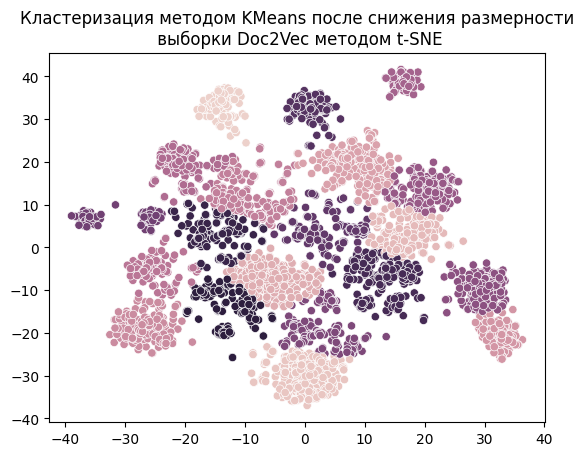

In [625]:
# Визуализируем выборку после снижения размероности методом t-SNE
ax = sns.scatterplot(doc2vec_tsne, x='tsne-1', y='tsne-2',
            hue=labels_best,
            legend=False);
ax.set(xlabel='', ylabel='',
         title = 'Кластеризация методом KMeans после снижения размерности\n выборки Doc2Vec методом t-SNE');

*На графике мы види отчетливые скопления точек, это говорит о том, что подробные описания товаров, которые выдал ИИ чемто взаимосвязаны между собой и их можно разделить на сегменты. Попробуем визуализировать в 3D виде. Для этого снизим размерность матрицы doc2vec до 3 измерений.*

In [626]:
# Уменьшим размерность выборки doc2vec до трех признаков
pipeline = Pipeline([
    #('scaler', StandardScaler()),
    ('tsne', TSNE(n_components=3, perplexity=55, random_state=100, metric='cosine'))])
doc2vec_tsne_3D = pd.DataFrame(pipeline.fit_transform(doc2vec), columns=['tsne-1', 'tsne-2', 'tsne-3'])

Максимальный показатель: 0.4201098680496216
Оптимальный алгоритм: KMeans, оптимальное кол-во кластеров: 23


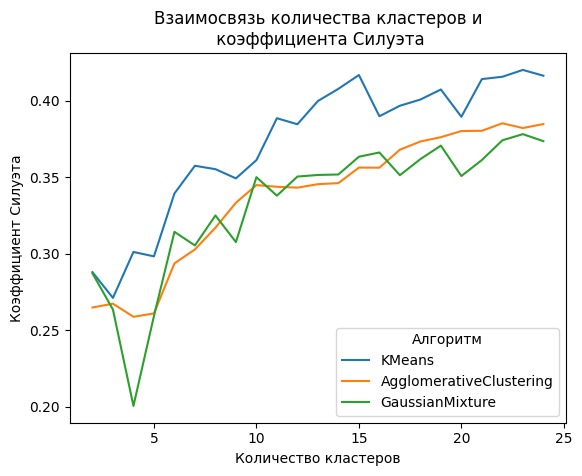

In [627]:
labels_best_3D = get_best_clustering(doc2vec_tsne_3D, 2, 25)

*Теперь мы получили скопления точек в 3D виде. Оптимальное количество кластеров в данном варианте снижения размерности отличается от варианта с двумя признаками. Кластеров получилось больше, и это не очень хорошо, т.к., чем меньше кластеров, тем легче их описать. Коэффициент Силуэта, снизился, поэтому для разметки описания товаров, мы возмем метки полученные при снижении размерности до двух признаков.*

In [628]:
fig = px.scatter_3d(doc2vec_tsne_3D, x='tsne-1', y='tsne-2', z='tsne-3',
                    color=labels_best_3D,
                    title='Сегментация товаров по описаниям',
                    height = 700)
fig.update_traces(marker_size = 3)
fig.show()

*Разметим выборку с описаниями товара метками класетров полученными при снижении размерноти до двух признаков методом t-SNE. Далее выведем для каждого кластера топовые слова, которые чаще всего стречаются в исходном описании товара.*

In [629]:
# Разметим каждое уникальное описание товара меткой кластера
DescriptionFull['StockCluster'] = labels_best

In [653]:
# Создадим словарь {кластер: корпус кластера}, кде копрус это словарь {слово: количество в корпусе}
clusters_corpus = {}
for cluster in DescriptionFull['StockCluster'].unique():
    descriptions = DescriptionFull[DescriptionFull['StockCluster']==cluster]['DescriptionClean'].values
    corpus = {}
    for description in descriptions:
        for word in description.split(' '):
            if corpus.get(word, 0):
                corpus[word] += 1
            else:
                corpus[word] = 1
    clusters_corpus[cluster] = corpus

# Создадим выборку в строках перечисляются топовые слова в соотвествующем кластере начиная с самых часто встречающихся
clusters_top_words = {}
for cluster in clusters_corpus:
    clusters_top_words[cluster] = [
        word[0] for word in sorted(clusters_corpus[cluster].items(), key=lambda s: s[1], reverse=True)[:10]]
print('Топ 10 слов в разрезе кластеров:')
pd.DataFrame(clusters_top_words).T.sort_index()

Топ 10 слов в разрезе кластеров:


,0,1,2,3,4,5,6,7,8,9
0,egg,easter,chocolate,bunny,rabbit,pink,cup,hanging,felt,basket
1,necklace,bracelet,glass,earrings,crystal,pink,black,silver,bead,heart
2,heart,home,decoration,zinc,large,sweet,hook,wicker,hanging,small
3,pink,blue,red,set,small,metal,heart,green,rose,hanging
4,paper,set,wrap,gift,christmas,vintage,pack,pink,party,honeycomb
5,candle,candles,set,incense,rose,holder,pink,silver,blue,dinner
6,bag,pink,design,red,vintage,jumbo,purse,retrospot,polkadot,lunch
7,set,pantry,wooden,magic,drawing,slate,kitchen,toy,mini,pack
8,cover,cushion,pink,blue,notebook,paisley,flower,red,passport,green
9,box,set,trinket,cutlery,sewing,design,kit,vintage,pink,retrospot


*И так если посмотреть на топовые слова кластера ноль, то можно сказать, что слова «яйцо», «Пасха», «шоколад», «кролик» и еще раз «кролик» связаны с празднованием Пасхи. Во время этого праздника принято дарить и получать в качестве подарков шоколадные яйца и шоколадных кроликов.*

*В кластере 6 топовыми словами являются: сад, набор, кладовая, розовая, магия. В этом контексте слова можно объединить, чтобы описать волшебный сад розового цвета, где в кладовой хранится набор волшебных инструментов. Это может быть декорация для сказки или фэнтези, где за садом ухаживает волшебный смотритель, который использует инструменты из кладовой, чтобы создавать и поддерживать очаровательную атмосферу сада.*

*Слова из кластера 12 можно объединить, чтобы создать концепцию «винтажной металлической банки», которую можно использовать в качестве декоративного предмета в доме. Слово «знак» напрямую в это понятие не вписывается, но его можно интерпретировать как металлический знак, прикрепленный к банке или выставленный рядом. Вот пример того, как эти слова могут использоваться вместе в предложении:*
     *Эта винтажная металлическая банка станет прекрасным дополнением к моему домашнему декору, а металлическая табличка на передней панели добавляет ей очаровательности.*
*В этом примере слово «металл» описывает материал банки, «винтаж» описывает ее стиль, «банка» — это сам объект, а «дом» — место, где объект находится. Слово «знак» используется для описания дополнительной особенности банки.*

*Есть доля вероятности, что данные наборы слов, просто совпадения, но давайте не будем слишком критически относится к полученному результату сегментирования товаров. Далее предлогаю использовать данную кластеризацию основой для сегментирования покупателей по интересам.*
*Создадим список кратких наименований категорий товаров по их описаниям, в порядке соотвествующем порядку катекогрий товаров, данный список нам призодится для описания сегментов покупателям по интересам.*

In [631]:
categories_stocks = [
            'Пасхальная тематика',
            'Настенный декор',
            'Кухонные принадлежности домашний декор одежда и аксессуары',
            'Рождественские украшения, декор для дома и сада, поделки',
            'Подсвечники и благовония',
            'Швейные принадлежности и средства для хранения',
            'Ювелирные изделия',
            'Сумки или кошельки',
            'Винтажные сумки и кошельки',
            'Бумага и расходные материалы для подарочной упаковки',
            'Декоративные кружки',
            'Дом и сад, кухня и столовая, декоративно-прикладное искусство',
            'Украшение и принадлежности для торта',
            'Разное: Мебель и домашний декор, посуда, канцелярские товары']

*P.S. Данные описания категорий товаров были составлены не без помощии ИИ.*

#### Сегментирование покупателей по их интересам

*И так мы получили сегменты товаров по описаниям, теперь давайте их используем для сегментирования покупателей по интересам. Для этого нам потредуется рассчитать частоту покупки каждой категории товаров для каждого клиента. Для начала, перенесем метки кластеров из набора данных уникальных описаний товара в справочник товаров.*

In [632]:
stocks_clustered = stocks.merge(DescriptionFull[['DescriptionClean', 'StockCluster']],
                    how='left', left_on='DescriptionClean', right_on='DescriptionClean')
stocks_clustered.head(5)

,StockCode,Description,DescriptionClean,StockCluster
0,10002,INFLATABLE POLITICAL GLOBE,inflatable political globe,18
1,10080,GROOVY CACTUS INFLATABLE,groovy cactus inflatable,3
2,10120,DOGGY RUBBER,doggy rubber,7
3,10123C,HEARTS WRAPPING TAPE,hearts wrapping tape,4
4,10124A,SPOTS ON RED BOOKCOVER TAPE,spots red bookcover tape,18


*Теперь нам необходимо перенести метки сегментов товаров из справочника товаров в основную выборку со всеми покупками.*

In [633]:
data_cleaned_stock_caterogy = data_cleaned.merge(
    stocks_clustered[['StockCode', 'StockCluster']], left_on='StockCode', right_on='StockCode')

*Далее необходимо закодировать категориальный признак сегмента товара однократным кодированием.*

In [634]:
encoder = OneHotEncoder()
data_cleaned_stock_caterogy = pd.concat([data_cleaned_stock_caterogy.drop(['StockCluster'], axis=1),
                                pd.DataFrame(encoder.fit_transform(
                                data_cleaned_stock_caterogy['StockCluster'].values.reshape(-1, 1)).toarray(),
                                columns=encoder.get_feature_names_out())], axis=1)
features = encoder.get_feature_names_out()
features

array(['x0_0', 'x0_1', 'x0_2', 'x0_3', 'x0_4', 'x0_5', 'x0_6', 'x0_7',
       'x0_8', 'x0_9', 'x0_10', 'x0_11', 'x0_12', 'x0_13', 'x0_14',
       'x0_15', 'x0_16', 'x0_17', 'x0_18', 'x0_19'], dtype=object)

*Мы получили для каждого кластера описаний товаров отдельный бинарный признак, или если хотите булевой.*
*Далее создадим отдельную выборку по покупетелям, в которой видно какой покупатель, сколько раз осуществлял покупки и по какой категории товара. В полученной выборке оставим только тех покупателей, которые есть в выборке RFMQ, это делается для того что бы визуализировать выборку RFMQ еще раз, но резмеченную кластерами интересов. И сравнить совпадают ли интересы у основной массы покупателей B2B и B2C.*

In [635]:
groupby1 = data_cleaned_stock_caterogy[data_cleaned_stock_caterogy['Quantity']>0].\
    groupby(['CustomerID','InvoiceNo'], as_index=False)[features].max()
customer_stock_caterogy_frequency = groupby1.groupby(['CustomerID'])[features].sum().sort_index()
customer_stock_caterogy_frequency = customer_stock_caterogy_frequency.loc[rfmq_table_cleaned.index]
print('Выборка частот покупки каждой категории товаров для каждого клиента:')
customer_stock_caterogy_frequency

Выборка частот покупки каждой категории товаров для каждого клиента:


,x0_0,x0_1,x0_2,x0_3,x0_4,x0_5,x0_6,x0_7,x0_8,x0_9,x0_10,x0_11,x0_12,x0_13,x0_14,x0_15,x0_16,x0_17,x0_18,x0_19
CustomerID,,,,,,,,,,,,,,,,,,,,
12346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12347,2.0,3.0,5.0,6.0,3.0,2.0,7.0,3.0,1.0,5.0,4.0,2.0,6.0,0.0,6.0,5.0,7.0,7.0,5.0,1.0
12350,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
12352,6.0,1.0,5.0,3.0,1.0,0.0,0.0,4.0,1.0,6.0,6.0,1.0,4.0,1.0,3.0,4.0,0.0,0.0,0.0,4.0
12353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18277,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18278,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
18280,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


*Теперь нам необходимо кластеризировать покупателей по интересам, для этого нам необходимо уменьшить полученную выборку частот покупки каждой категории товаров для каждого клиента до двухвекторного пространства, предварительно стандартирировав все признаки.*

In [636]:
# Уменьшим размерность выборки до двух признаков
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('tsne', TSNE(n_components=2, perplexity=195, metric='cosine', random_state=100))])
customer_stock_caterogy_frequency_tsne = pd.DataFrame(pipeline.fit_transform(customer_stock_caterogy_frequency),
             columns=['tsne-1', 'tsne-2'])

*Выберем оптимальный алгоритм кластеризации и оптимальное количество кластеров.*

Максимальный показатель: 0.6336354613304138
Оптимальный алгоритм: KMeans, оптимальное кол-во кластеров: 2


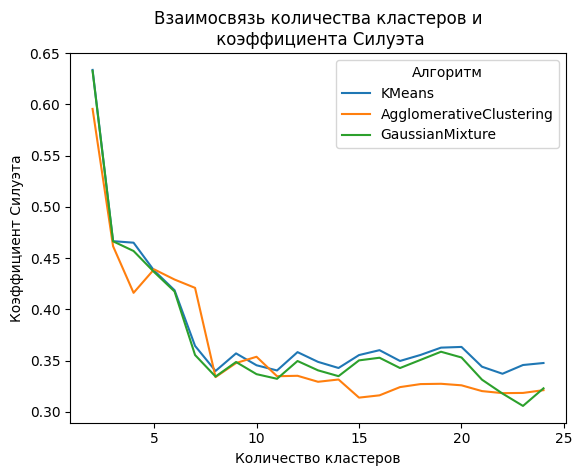

In [637]:
labels_best = get_best_clustering(customer_stock_caterogy_frequency_tsne, 2, 25)

*Выборка снижена до двух признаков и наивысший коэффициент Силуэта соответствует двум кластерам. Но это слишком мало, поэтому возьмем больше, т.к. по факту категорий по интересам должно быть больше. По графику мы видим, что 9 кластеров тоже дастигает не плохой коэффициент силуета. Вновь кластеризируем оптимальным алгоритмом и визуализируем полученную выборку размеченную на 9 кластеров.*

In [638]:
# Кластеризируем выборку при использовании оптимального алгоритма и ооптимального количества кластеров
agglomerativeclustering =  AgglomerativeClustering(n_clusters=9)
agglomerativeclustering.fit(customer_stock_caterogy_frequency_tsne);
labels_best = agglomerativeclustering.labels_

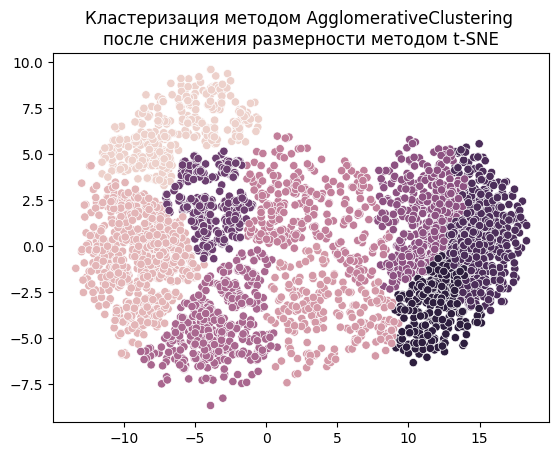

In [639]:
# Визуализируем выборку после снижения размероности методом t-SNE
ax = sns.scatterplot(customer_stock_caterogy_frequency_tsne, x='tsne-1', y='tsne-2', hue=labels_best, legend=False);
ax.set(xlabel='', ylabel='',
         title = 'Кластеризация методом AgglomerativeClustering \nпосле снижения размерности методом t-SNE');

*Будем считать покупатели делятся на 9 сегментов по интересам. Теперь давайте снова визуализируем RFM-выборку, но уже размеченную метками сегментов по интересам.*

In [640]:
fig = px.scatter_3d(rfmq_table_cleaned, x='Recency', y='Frequency', z='Monetary',
                    color=labels_best,
                    title='Взаимосвязь признаков RFM-выборки. Кластеризация по интересам',
                    height = 700)
fig.update_traces(marker_size = 3)
fig.show()

*Исходя из данной визуализации, какие можно сделать выводы? Можно с большой вероятностью предположить, что оптовые и розничные покупатели деляться множестово разных категирий по предпочтениям. Для большей наглядности нам необходимо проверить данные категории в разрезе показателя Quantity. Визуализируем выборку RFMQ в разрезе интересов в виде полярной диаграммы.*

In [641]:
rfmq_table_cleaned['InterestsCluster'] = labels_best
grouped_data = rfmq_table_cleaned[
    ['Recency', 'Frequency', 'Monetary', 'Quantity', 'InterestsCluster']].groupby('InterestsCluster').mean()
print('Средние показатели RFMQ-выборки в разрезе сегментов по интересам:')
grouped_data

Средние показатели RFMQ-выборки в разрезе сегментов по интересам:


,Recency,Frequency,Monetary,Quantity
InterestsCluster,,,,
0,153.777251,1.516588,459.477370,175.180095
1,138.179628,1.469880,333.664819,117.074480
2,64.414747,3.211982,940.167650,173.930876
3,65.636691,3.575540,971.684460,132.517986
4,116.576520,1.710692,443.255241,153.215933
5,45.727528,5.646067,1789.941826,166.491573
6,133.470588,1.338235,406.508765,156.567647
7,43.230241,5.376289,1891.209880,192.369416
8,37.925926,6.003367,2025.515623,194.107744


In [642]:
# Добавим строку с нулями для правильного маштабирования
#grouped_data.loc[grouped_data.shape[0]]=0
# Нормализуем набор данных
scaler = StandardScaler()
grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data),
                    columns=grouped_data.columns, index=grouped_data.index)
# Удалим строку с нулями
grouped_data.drop(grouped_data.tail(1).index, inplace=True)
# Визуализируем полярную диаграмму
plot_cluster_profile(grouped_data)

*Мы видим, что как оптовые так и розничные покупатели делятся на разные катогории предпочтений.*
*Предлогаю рассмотреть из каких категорий товаров состоят сегменты по интересам.*

In [643]:
customer_stock_caterogy_frequency['InterestsCluster'] = labels_best
grouped_data = customer_stock_caterogy_frequency[
    ['InterestsCluster'] + list(features)].groupby('InterestsCluster').sum()
print('Средние показатели выборки частот покупки каждой категории товаров для каждого клиента')
print('в разрезе сегментов товаров по описаниям:')
# Переименуем наименования столбцов для наилучшего восприятия
columns = dict([(features[i], name_caterory) for i, name_caterory in enumerate(categories_stocks)])
grouped_data = grouped_data.rename(columns=columns)
grouped_data

Средние показатели выборки частот покупки каждой категории товаров для каждого клиента
в разрезе сегментов товаров по описаниям:


,Пасхальная тематика,Настенный декор,Кухонные принадлежности домашний декор одежда и аксессуары,"Рождественские украшения, декор для дома и сада, поделки",Подсвечники и благовония,Швейные принадлежности и средства для хранения,Ювелирные изделия,Сумки или кошельки,Винтажные сумки и кошельки,Бумага и расходные материалы для подарочной упаковки,Декоративные кружки,"Дом и сад, кухня и столовая, декоративно-прикладное искусство",Украшение и принадлежности для торта,"Разное: Мебель и домашний декор, посуда, канцелярские товары",x0_14,x0_15,x0_16,x0_17,x0_18,x0_19
InterestsCluster,,,,,,,,,,,,,,,,,,,,
0,466.0,101.0,277.0,378.0,372.0,200.0,300.0,377.0,180.0,364.0,281.0,289.0,232.0,161.0,220.0,320.0,233.0,214.0,288.0,242.0
1,11.0,16.0,443.0,476.0,550.0,4.0,478.0,476.0,223.0,420.0,329.0,366.0,413.0,167.0,197.0,342.0,229.0,288.0,335.0,278.0
2,58.0,76.0,172.0,373.0,396.0,79.0,390.0,404.0,204.0,384.0,287.0,220.0,218.0,117.0,190.0,260.0,208.0,166.0,314.0,278.0
3,122.0,327.0,492.0,449.0,393.0,75.0,267.0,419.0,121.0,324.0,363.0,406.0,472.0,206.0,216.0,327.0,205.0,390.0,198.0,204.0
4,40.0,180.0,348.0,384.0,399.0,548.0,278.0,378.0,161.0,324.0,316.0,321.0,460.0,162.0,222.0,287.0,198.0,265.0,301.0,219.0
5,427.0,626.0,1259.0,1225.0,1052.0,270.0,786.0,1168.0,378.0,874.0,769.0,1017.0,1132.0,529.0,539.0,998.0,463.0,1035.0,799.0,656.0
6,105.0,338.0,214.0,247.0,225.0,0.0,172.0,232.0,97.0,235.0,210.0,223.0,175.0,122.0,183.0,188.0,111.0,150.0,205.0,129.0
7,1279.0,1206.0,2024.0,2323.0,2181.0,1451.0,1859.0,2252.0,1412.0,2104.0,1772.0,1855.0,2077.0,1128.0,1637.0,1991.0,1414.0,1754.0,1847.0,1626.0
8,375.0,293.0,720.0,1094.0,1218.0,179.0,1332.0,1170.0,733.0,1129.0,756.0,750.0,638.0,395.0,603.0,782.0,734.0,535.0,895.0,766.0


*Мы видим, что оптовики проявляют свой интерес ко всем категориям товара, в то время как розница разделилась на три сегмента по интересам, в каждом из которых частоты слабо совпадают.*

In [644]:
# Стандартизируем набор данных
scaler = StandardScaler()
grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data),
                    columns=grouped_data.columns, index=grouped_data.index)
# Визуализируем полярную диаграмму
plot_cluster_profile(grouped_data)

*И так, мы наблюдаем, что есть категория покупателей среди оптовых, которая охватывает наибольший спектр предпочтений, хотя и эту категорию можно было бы разделить на еще несколько, увеличив параметр клатеризации, но к идеалу можно стремиться бесконечно, это слишком дорого, приблизительность обходится дешевле.*

#### Выявление сезонных и постоянных покупателей.

*Для начала применим однократное кодирование категориальному признаку Month, полученные бинарные признаки и все остальные кроме Month поместим в отдельный датасет*

In [645]:
encoder = OneHotEncoder()

data_cleaned_month_caterogy = pd.concat([data_cleaned.drop('Month', axis=1).reset_index(),
                                pd.DataFrame(encoder.fit_transform(
                                data_cleaned['Month'].values.reshape(-1, 1)).toarray(),
                                columns=encoder.get_feature_names_out())], axis=1)
features = encoder.get_feature_names_out()
features

array(['x0_1', 'x0_2', 'x0_3', 'x0_4', 'x0_5', 'x0_6', 'x0_7', 'x0_8',
       'x0_9', 'x0_10', 'x0_11', 'x0_12'], dtype=object)

*Создадим отдельный датасет по каждому покупателю с частотами покупок в кадом мясяце и очистим от выбросов*

In [646]:
groupby1 = data_cleaned_month_caterogy[data_cleaned_month_caterogy['Quantity']>0].groupby(['CustomerID', 'InvoiceNo'])[features].max()
customer_month_caterogy_frequency = groupby1.groupby('CustomerID')[features].sum()
customer_month_caterogy_frequency = customer_month_caterogy_frequency.loc[rfmq_table_cleaned.index]
print('Выборка частот покупок клиентами по месяцам:')
customer_month_caterogy_frequency.head(5)

Выборка частот покупок клиентами по месяцам:


,x0_1,x0_2,x0_3,x0_4,x0_5,x0_6,x0_7,x0_8,x0_9,x0_10,x0_11,x0_12
CustomerID,,,,,,,,,,,,
12346,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12347,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0
12350,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12352,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0
12353,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


*Приступим к уменьшению размерности методом t-SNE для последующей кластеризации*

In [647]:
# Уменьшим размерность выборки до двух признаков
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('tsne', TSNE(n_components=2, perplexity=54, metric='cosine', random_state=100))])
customer_month_caterogy_frequency_tsne = pd.DataFrame(pipeline.fit_transform(customer_month_caterogy_frequency),
             columns=['tsne-1', 'tsne-2'])

*Подберем оптимальный алгоритм и количество кластеров для кластеризации*

Максимальный показатель: 0.5672416090965271
Оптимальный алгоритм: KMeans, оптимальное кол-во кластеров: 23


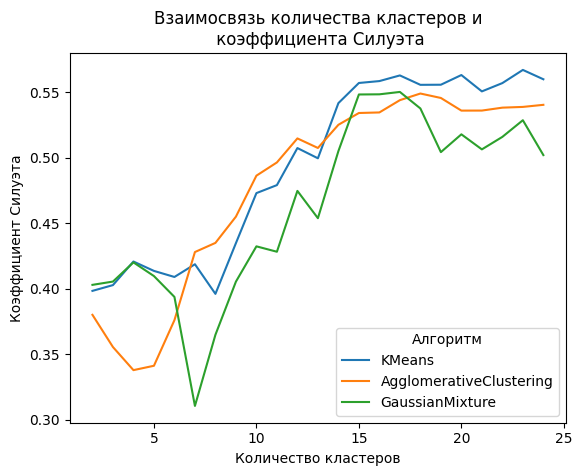

In [648]:
labels_best = get_best_clustering(customer_month_caterogy_frequency_tsne, 2, 25)

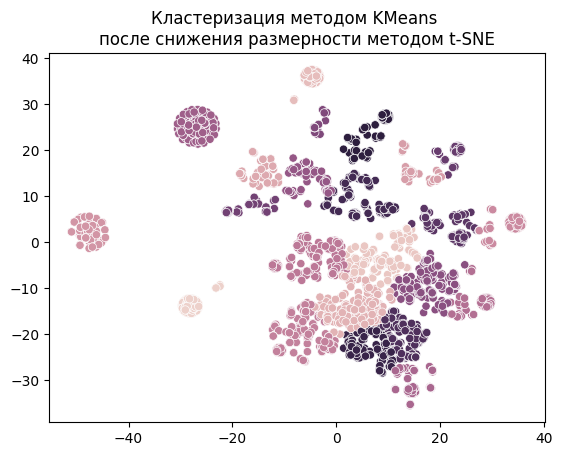

In [649]:
# Визуализируем выборку после снижения размероности методом t-SNE
ax = sns.scatterplot(customer_month_caterogy_frequency_tsne, x='tsne-1', y='tsne-2', hue=labels_best, legend=False);
ax.set(xlabel='', ylabel='',
         title = 'Кластеризация методом KMeans \nпосле снижения размерности методом t-SNE');

In [650]:
categories_month = ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']
customer_month_caterogy_frequency['SeasonCluster'] = labels_best
grouped_data = customer_month_caterogy_frequency[
    ['SeasonCluster'] + list(features)].groupby('SeasonCluster').sum()
print('Средние показатели выборки частот покупки товаров в каждый месяц для каждого клиента')
print('в разрезе сегментов товаров по описаниям:')
# Переименуем наименования столбцов для наилучшего восприятия
columns = dict([(features[i], name_caterory) for i, name_caterory in enumerate(categories_month)])
grouped_data = grouped_data.rename(columns=columns)
grouped_data

Средние показатели выборки частот покупки товаров в каждый месяц для каждого клиента
в разрезе сегментов товаров по описаниям:


,Январь,Февраль,Март,Апрель,Май,Июнь,Июль,Август,Сентябрь,Октябрь,Ноябрь,Декабрь
SeasonCluster,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,180.0
1,4.0,2.0,150.0,30.0,86.0,54.0,132.0,82.0,61.0,68.0,109.0,49.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,0.0,0.0,14.0
3,167.0,81.0,188.0,76.0,168.0,162.0,107.0,146.0,110.0,129.0,191.0,326.0
4,2.0,2.0,2.0,0.0,0.0,1.0,0.0,2.0,6.0,202.0,173.0,87.0
5,1.0,1.0,0.0,0.0,99.0,26.0,0.0,0.0,46.0,38.0,35.0,14.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,225.0,0.0
7,0.0,0.0,196.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,29.0,24.0
8,329.0,4.0,16.0,53.0,43.0,43.0,35.0,35.0,59.0,59.0,100.0,83.0


*Визуализируем полученную сводную таблицу в тепловой диаграмме.*

<Axes: ylabel='SeasonCluster'>

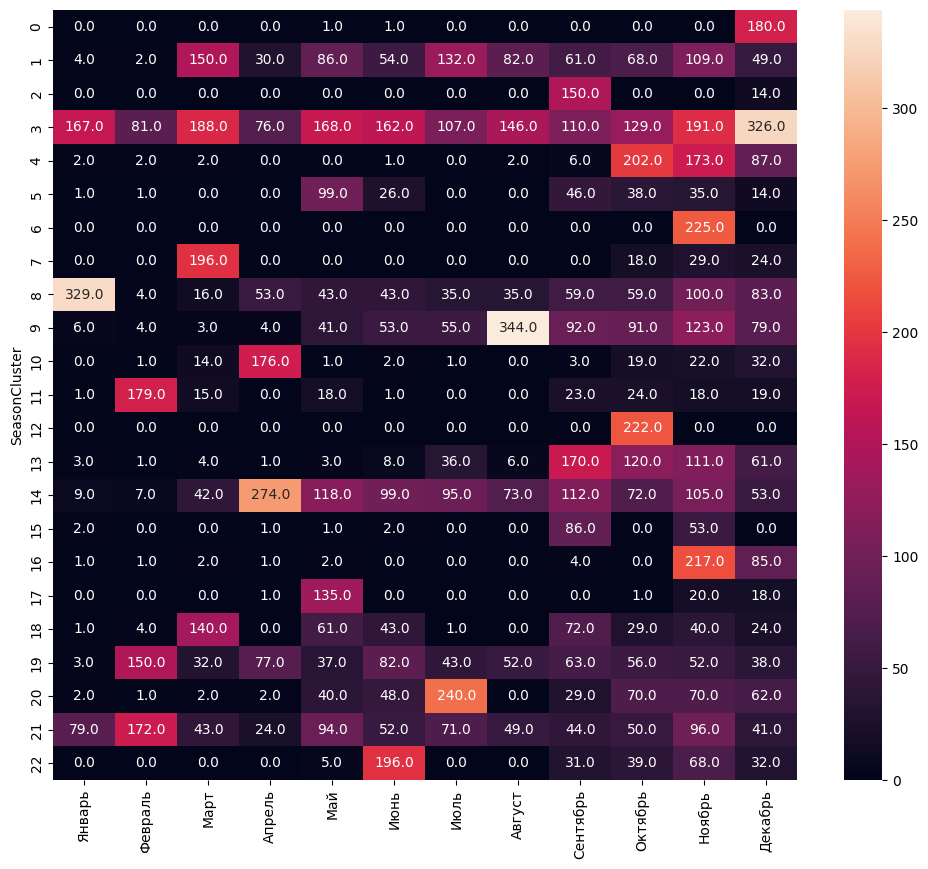

In [651]:
fig, axes = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(grouped_data, annot=True, fmt=".1f", ax=axes)

*Как видим обнаружен два кластера, в котором покупатели стабильно совершают покупки каждый месяц, определенными перепадами частот. Это значит эти кластеры относится к постояным клиентам. При необходимости эти два кластера можно объединить, но тогда теряется информация о перепадах частот по месяцам. Нельзя сказать что другие кластеры относятся к постоянным клиентам. Хотя есть и такие кластеры в которых покупки совершаются каждый месяц, но менее стабильно. Покупки совершаемые в количестве нескольких единиц в месяц, скорее всего нельзя считать значимыми. Поэтому такие покупатели не являются постоянными, но и сезонными их тоже не назовешь, скорее всего, это новые покупатели, которые набирают обороты и вскоре будут постоянными. Покупатели находящиеся в других кластерах являются сезонными.*